<a href="https://colab.research.google.com/github/MaheenGitHub/human-activity-recognition-ML/blob/main/Sequence-Based%20Deep%20Learning%20Classification/Sequence_Based_Deep_Learning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Deliverable 4
## Sequence-Based Deep Learning Classification (RNN / LSTM / GRU)



             
**Dataset:** UCI Human Activity Recognition (HAR)


In [ ]:
#@title  Setup & Environment Configuration
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Connect to Drive
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/ITF22_HAR_Project'
os.makedirs(BASE_PATH, exist_ok=True)

# Path to the zip file - wrapped in quotes to handle spaces
zip_path = os.path.join(BASE_PATH, 'UCI_HAR_Dataset.zip')

# Check if the 'train' folder exists; if not, we need to extract
if not os.path.exists(os.path.join(BASE_PATH, 'train')):
    print("Data directory not found or incomplete. Starting fresh extraction...")

    # Download the dataset if the zip doesn't exist locally
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        # Use quotes around the path variable to prevent shell splitting
        !wget -q -O "{zip_path}" "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

    print("Extracting files...")
    # Use quotes around paths to handle spaces correctly
    !unzip -o -q "{zip_path}" -d "{BASE_PATH}"

    # The UCI dataset unzips into a folder called 'UCI HAR Dataset'
    # We move its contents to BASE_PATH so our code stays 'on point'
    extracted_folder = os.path.join(BASE_PATH, 'UCI HAR Dataset')
    if os.path.exists(extracted_folder):
        # Using a wildcard move via shell
        !mv "{extracted_folder}"/* "{BASE_PATH}/"
        !rmdir "{extracted_folder}"
    print("Dataset verified and structure standardized.")
else:
    print("Data directory found. Ready to proceed.")

print(f"Working directory ready: {BASE_PATH}")

Mounted at /content/drive
Data directory not found or incomplete. Starting fresh extraction...
Extracting files...
rmdir: failed to remove '/content/drive/MyDrive/ITF22_HAR_Project/UCI HAR Dataset': Directory not empty
Dataset verified and structure standardized.
Working directory ready: /content/drive/MyDrive/ITF22_HAR_Project


In [ ]:
#@title  Raw Signal Loading (Inertial Signals)
def load_raw_signals(subset):
    path = os.path.join(BASE_PATH, subset, 'Inertial Signals')
    signals = ['body_acc_x_', 'body_acc_y_', 'body_acc_z_',
               'body_gyro_x_', 'body_gyro_y_', 'body_gyro_z_',
               'total_acc_x_', 'total_acc_y_', 'total_acc_z_']

    data = []
    for signal in signals:
        filename = os.path.join(path, f'{signal}{subset}.txt')
        # High-level move: Using sep='\s+' handles irregular spacing in raw txt files
        df = pd.read_csv(filename, header=None, sep='\s+')
        data.append(df.values)

    # Transpose to shape: (Samples, TimeSteps, Features) -> (N, 128, 9)
    return np.transpose(np.array(data), (1, 2, 0))

def load_labels(subset):
    filename = os.path.join(BASE_PATH, subset, f'y_{subset}.txt')
    y = pd.read_csv(filename, header=None, sep='\s+')
    return y.values.ravel()

X_train_raw = load_raw_signals('train')
X_test_raw = load_raw_signals('test')
y_train_raw = load_labels('train')
y_test_raw = load_labels('test')

print(f"Raw Data Loaded. Train Shape: {X_train_raw.shape}") # Should be (7352, 128, 9)

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2533725520.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filename, header=None, sep='\s+')
/tmp/ipython-input-2533725520.py:20: SyntaxWarning: invalid escape sequence '\s'
  y = pd.read_csv(filename, header=None, sep='\s+')


Raw Data Loaded. Train Shape: (7352, 128, 9)


In [ ]:
#@title Normalization & Label Encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Shift labels (1-6) to zero-based index (0-5)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# Scaling 3D data: Flatten, Scale, then Reshape back
scaler = StandardScaler()
X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_seq = scaler.fit_transform(X_train_reshaped).reshape(X_train_raw.shape)

X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[-1])
X_test_seq = scaler.transform(X_test_reshaped).reshape(X_test_raw.shape)

print(" Data normalized. Sequence format ready for Deep Learning.")

 Data normalized. Sequence format ready for Deep Learning.


In [ ]:
#@title  Architecture Factory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

def build_model(model_type, input_shape=(128, 9)):
    model = Sequential([Input(shape=input_shape)])

    if model_type == 'RNN':
        model.add(SimpleRNN(128))
    elif model_type == 'LSTM':
        model.add(LSTM(128))
    elif model_type == 'GRU':
        model.add(GRU(128))

    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Advanced Move: Automatically reduce learning rate if the model stops improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [ ]:
#@title  Simple RNN Execution
rnn_model = build_model('RNN')
rnn_cp = ModelCheckpoint(os.path.join(BASE_PATH, 'best_rnn.keras'), save_best_only=True, monitor='val_accuracy')

print("Training RNN...")
history_rnn = rnn_model.fit(X_train_seq, y_train, epochs=30, batch_size=32,
                            validation_split=0.2, callbacks=[rnn_cp, lr_reducer], verbose=1)

Training RNN...
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5035 - loss: 1.2849 - val_accuracy: 0.6961 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6687 - loss: 0.7392 - val_accuracy: 0.7498 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7196 - loss: 0.6356 - val_accuracy: 0.7165 - val_loss: 0.7226 - learning_rate: 0.0010
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6829 - loss: 0.7618 - val_accuracy: 0.7593 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7270 - loss: 0.6618 - val_accuracy: 0.7213 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7500 - loss: 0.5759 - val_accuracy: 0.8375 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0

In [ ]:
#@title  LSTM Execution
lstm_model = build_model('LSTM')
lstm_cp = ModelCheckpoint(os.path.join(BASE_PATH, 'best_lstm.keras'), save_best_only=True, monitor='val_accuracy')

print("Training LSTM...")
history_lstm = lstm_model.fit(X_train_seq, y_train, epochs=30, batch_size=32,
                              validation_split=0.2, callbacks=[lstm_cp, lr_reducer], verbose=1)

Training LSTM...
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5607 - loss: 1.0848 - val_accuracy: 0.8797 - val_loss: 0.4319 - learning_rate: 0.0010
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8524 - loss: 0.4153 - val_accuracy: 0.7995 - val_loss: 0.4870 - learning_rate: 0.0010
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8995 - loss: 0.2876 - val_accuracy: 0.8756 - val_loss: 0.3185 - learning_rate: 0.0010
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9352 - loss: 0.1742 - val_accuracy: 0.8844 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9502 - loss: 0.1337 - val_accuracy: 0.9075 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9519 - loss: 0.1266 - val_accuracy: 0.8967 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.94

In [ ]:
#@title  GRU Execution
gru_model = build_model('GRU')
gru_cp = ModelCheckpoint(os.path.join(BASE_PATH, 'best_gru.keras'), save_best_only=True, monitor='val_accuracy')

print("Training GRU...")
history_gru = gru_model.fit(X_train_seq, y_train, epochs=30, batch_size=32,
                            validation_split=0.2, callbacks=[gru_cp, lr_reducer], verbose=1)

Training GRU...
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4933 - loss: 1.2252 - val_accuracy: 0.8742 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9152 - loss: 0.2322 - val_accuracy: 0.8953 - val_loss: 0.3826 - learning_rate: 0.0010
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9537 - loss: 0.1253 - val_accuracy: 0.8994 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9538 - loss: 0.1133 - val_accuracy: 0.8953 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9588 - loss: 0.1099 - val_accuracy: 0.9075 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9400 - loss: 0.1530 - val_accuracy: 0.8933 - val_loss: 0.3655 - learning_rate: 0.0010
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.

In [ ]:
#@title  Comparative Performance Table
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

def evaluate_model(name, model_path):
    model = tf.keras.models.load_model(model_path)

    # Measure Latency (Time for 100 samples)
    start = time.time()
    y_pred_probs = model.predict(X_test_seq, verbose=0)
    latency = (time.time() - start) / len(X_test_seq) * 1000 # ms per sample

    y_pred = np.argmax(y_pred_probs, axis=1)

    return {
        'Model': name,
        'Accuracy (%)': f"{accuracy_score(y_test, y_pred)*100:.2f}%",
        'F1-Score': round(f1_score(y_test, y_pred, average='macro'), 4),
        'Precision': round(precision_score(y_test, y_pred, average='macro'), 4),
        'Recall': round(recall_score(y_test, y_pred, average='macro'), 4),
        'Latency (ms)': round(latency, 4)
    }

summary = []
for m in ['RNN', 'LSTM', 'GRU']:
    summary.append(evaluate_model(m, os.path.join(BASE_PATH, f'best_{m.lower()}.keras')))

comparison_df = pd.DataFrame(summary)
print("\n--- FINAL SYSTEM BENCHMARK ---")
print(comparison_df.to_string(index=False))


--- FINAL SYSTEM BENCHMARK ---
Model Accuracy (%)  F1-Score  Precision  Recall  Latency (ms)
  RNN       85.65%    0.8555     0.8552  0.8581        0.7653
 LSTM       91.25%    0.9140     0.9143  0.9151        0.4746
  GRU       90.46%    0.9064     0.9060  0.9077        0.4642


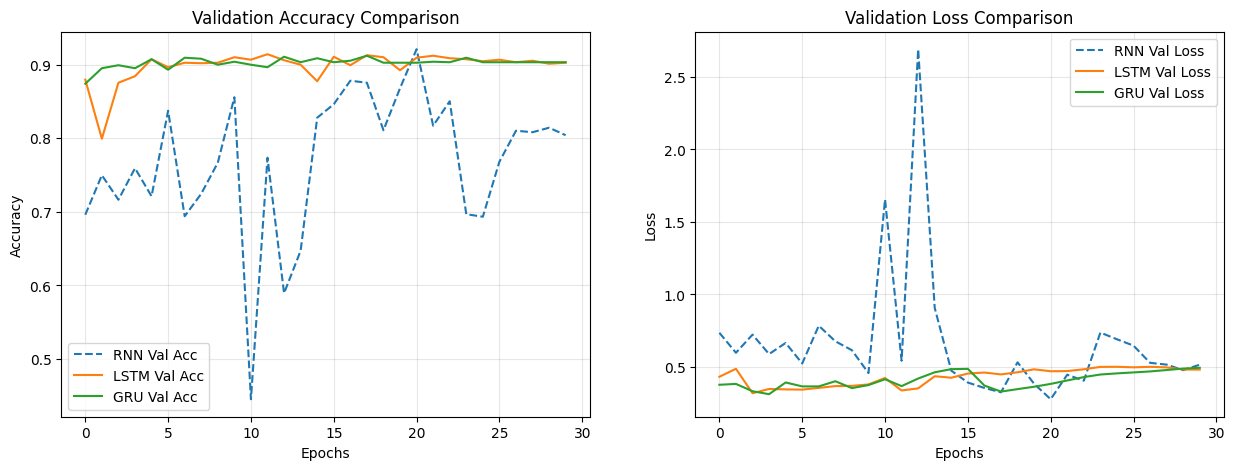

In [ ]:
#@title  Learning Convergence Visualization
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val Acc', linestyle='--')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Acc')
plt.plot(history_gru.history['val_accuracy'], label='GRU Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['val_loss'], label='RNN Val Loss', linestyle='--')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-663996763.py:5: SyntaxWarning: invalid escape sequence '\s'
  activity_labels = pd.read_csv(os.path.join(BASE_PATH, 'activity_labels.txt'), header=None, sep='\s+')[1].values


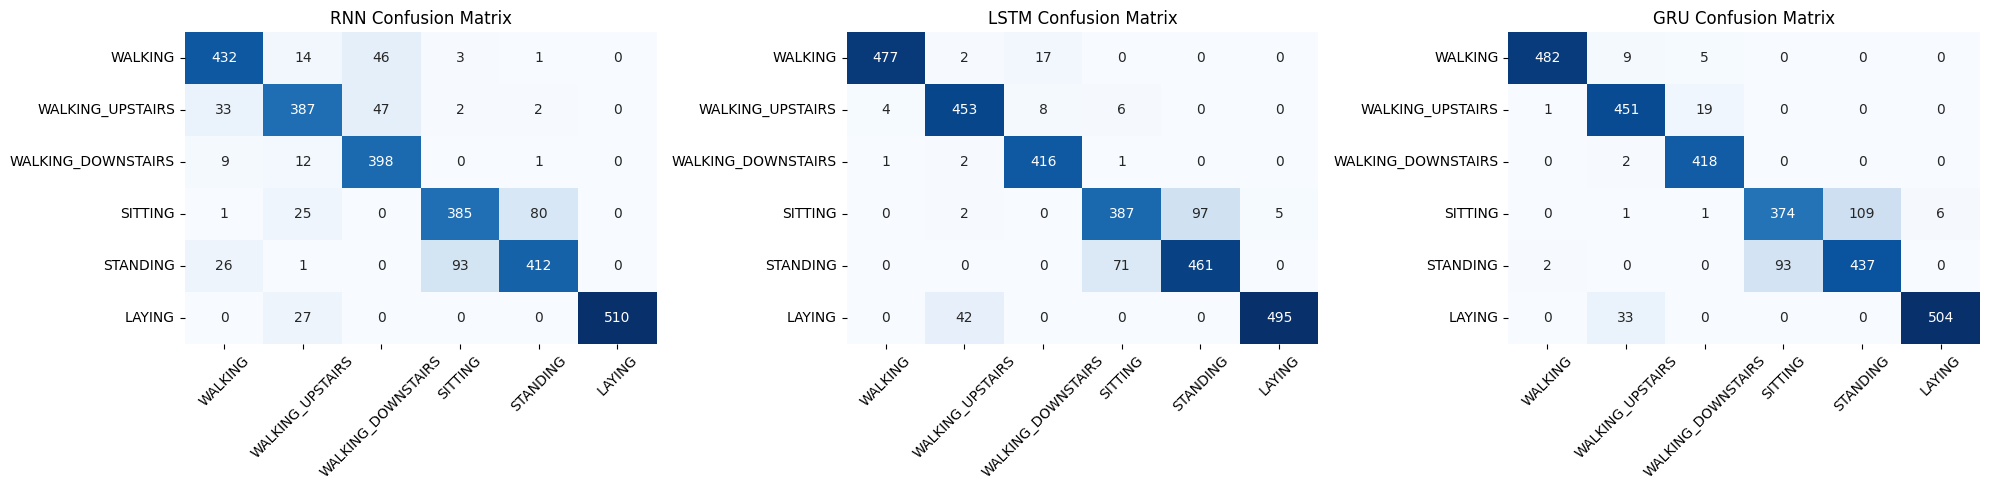

In [ ]:
#@title  Error Analysis: Confusion Matrix Grid
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
activity_labels = pd.read_csv(os.path.join(BASE_PATH, 'activity_labels.txt'), header=None, sep='\s+')[1].values

for i, m in enumerate(['RNN', 'LSTM', 'GRU']):
    model = tf.keras.models.load_model(os.path.join(BASE_PATH, f'best_{m.lower()}.keras'))
    y_pred = np.argmax(model.predict(X_test_seq, verbose=0), axis=1)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=activity_labels, yticklabels=activity_labels)
    axes[i].set_title(f'{m} Confusion Matrix')
    axes[i].set_xticklabels(activity_labels, rotation=45)

plt.tight_layout()
plt.show()

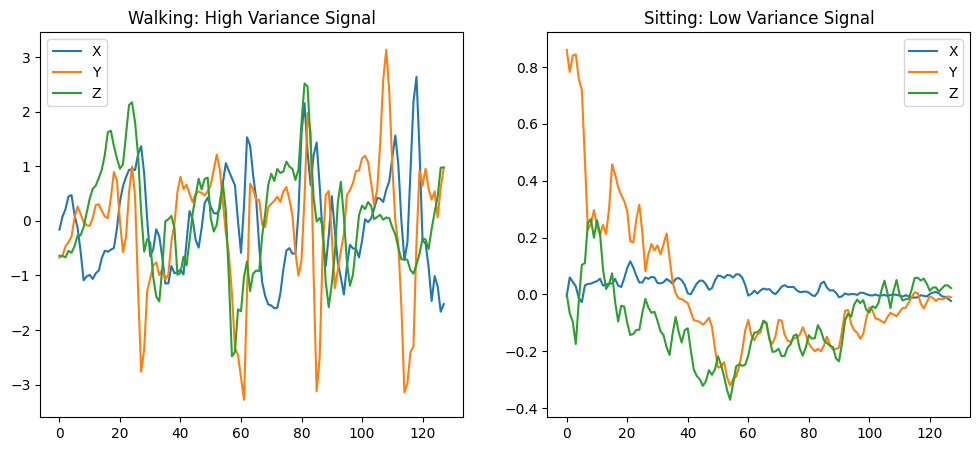

In [ ]:
#@title  Signal Pattern Analysis
sample_walking = X_test_seq[y_test == 0][0]
sample_sitting = X_test_seq[y_test == 3][0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sample_walking[:, :3])
plt.title("Walking: High Variance Signal")
plt.legend(['X', 'Y', 'Z'])

plt.subplot(1, 2, 2)
plt.plot(sample_sitting[:, :3])
plt.title("Sitting: Low Variance Signal")
plt.legend(['X', 'Y', 'Z'])
plt.show()

In [ ]:
#@title  Permanent Storage & Recovery Setup
import os
import pickle # Standard for saving variables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Set Path (Using the same path from your main notebook)
BASE_PATH = '/content/drive/MyDrive/ITF22_HAR_Project'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
    print(f"Created new directory: {BASE_PATH}")

# 3. Path for the data backup file
CHECKPOINT_FILE = os.path.join(BASE_PATH, 'session_data.pkl')

print(f"Recovery System Active. Path: {BASE_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Recovery System Active. Path: /content/drive/MyDrive/ITF22_HAR_Project


In [ ]:
#@title  Backup/Restore Functions
def save_work():
    """Call this after Cell 3 to save your processed X and y arrays."""
    data_to_save = {
        'X_train': X_train_seq,
        'X_test': X_test_seq,
        'y_train': y_train,
        'y_test': y_test
    }
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(" Processed data backed up to Google Drive successfully.")

def load_work():
    """Call this if the session restarts to jump straight to training/testing."""
    global X_train_seq, X_test_seq, y_train, y_test
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'rb') as f:
            data = pickle.load(f)
        X_train_seq = data['X_train']
        X_test_seq = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']
        print("Data restored. You can skip preprocessing cells now.")
    else:
        print("No backup found. You need to run the data loading cells first.")